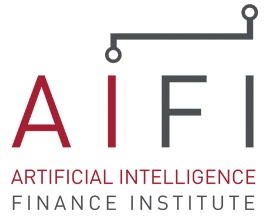


# Bootcamp - Python and Coding - Supervised Machine Learning

# Machine Learning with scikit-learn – Classification 

# About this notebook

The goal of this notebook is to demonstrate how to predict whether the current signal for bitcoin is **buy or sell**, depending on the short-term or long-term price, using classification models from [scikit-learn](https://scikit-learn.org/stable/). Furthermore, this notebook shows examples how to conduct an exploratory data analysis (EDA) in Python and how to prepare the data for the models. Hence, we will put our focus on the following: 

- Building a trading strategy using classification (classification of long/short signals).
- Feature engineering and constructing technical indicators of trend, momentum, and mean reversion.
- Building a framework for backtesting results of a trading strategy.
- Choosing the right evaluation metric to assess a trading strategy.

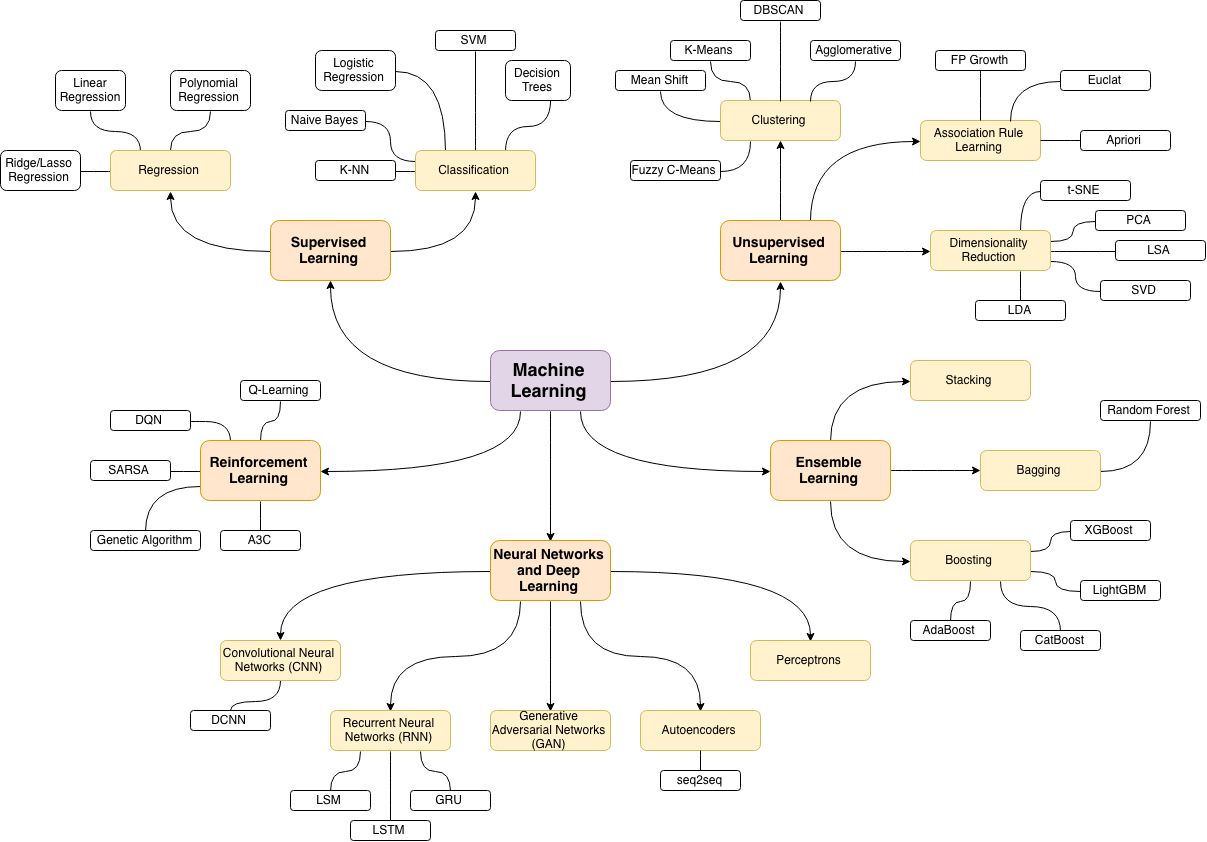

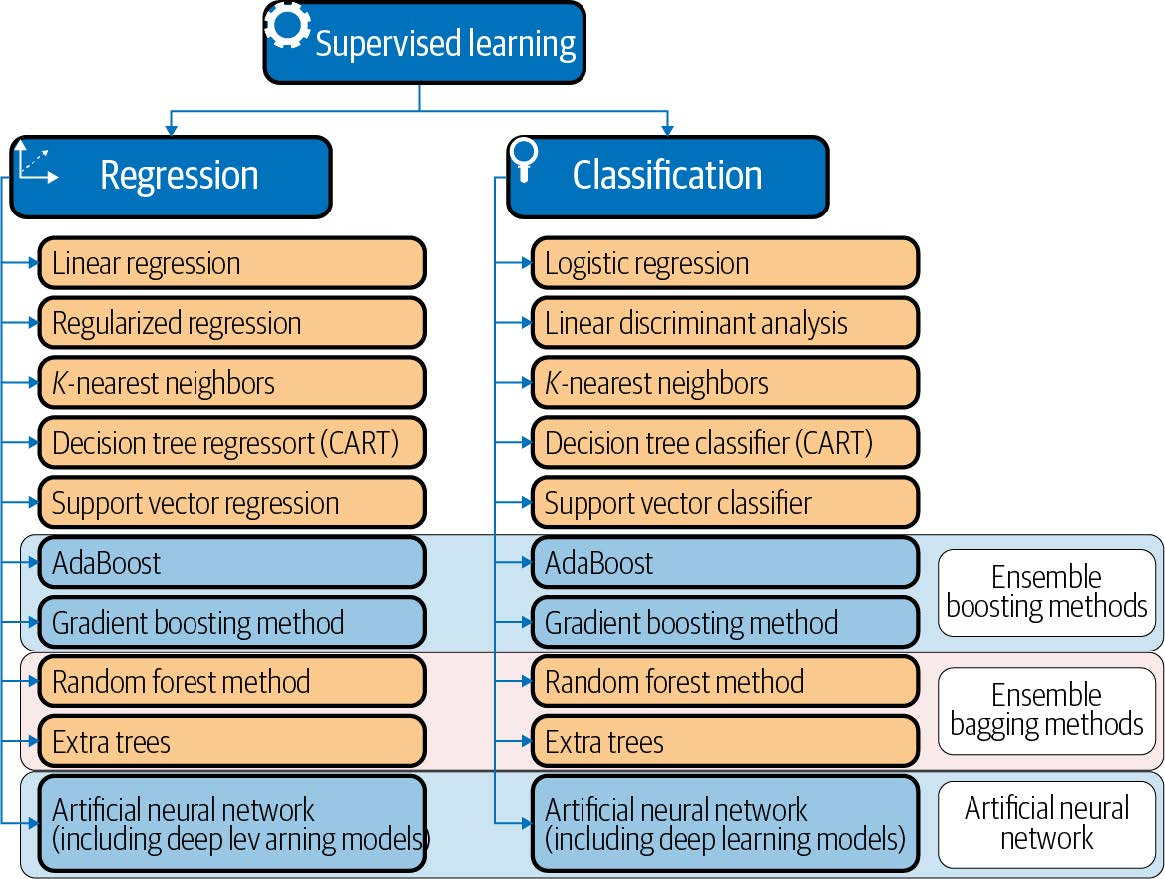

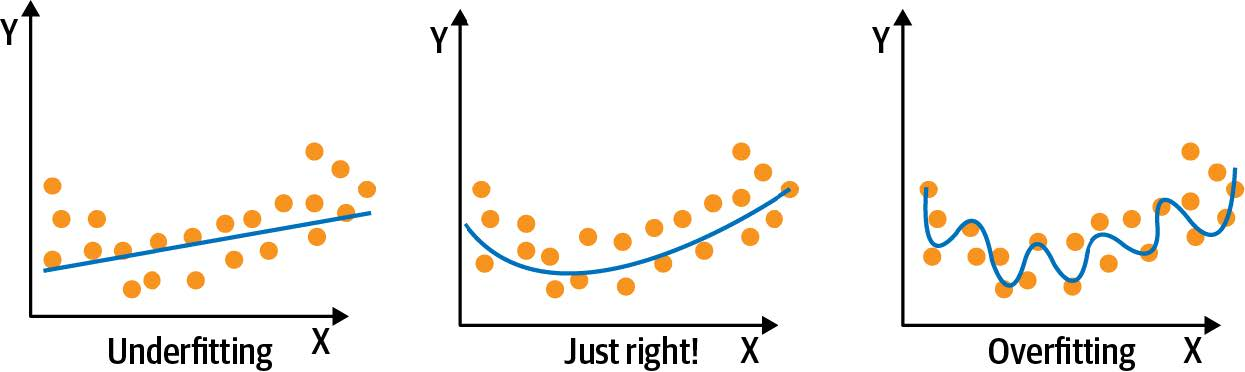

There can be two ways to combat overfitting:
- **Using more training data**
    * The more training data we have, the harder it is to overfit the data by learning too much from any single training example.

- **Using regularization**
    * Adding a penalty in the loss function for building a model that assigns too much explanatory power to any one feature, or allows too many features to be taken into account. The concept of overfitting and the ways to combat it are applicable across all the supervised learning models. For example, regularized regressions address overfitting in linear regression, as it discussed  in the `regression notebook`.

# Cross Validation

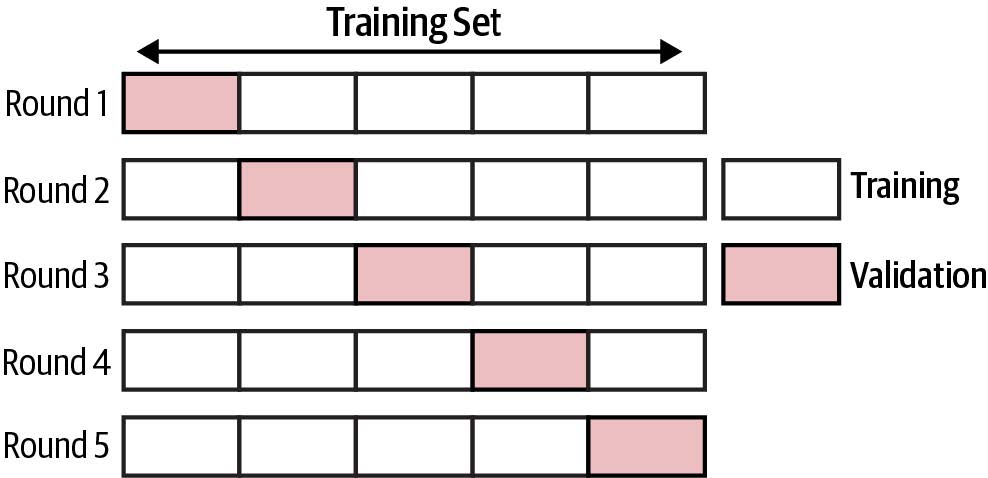

## Times series cross validation

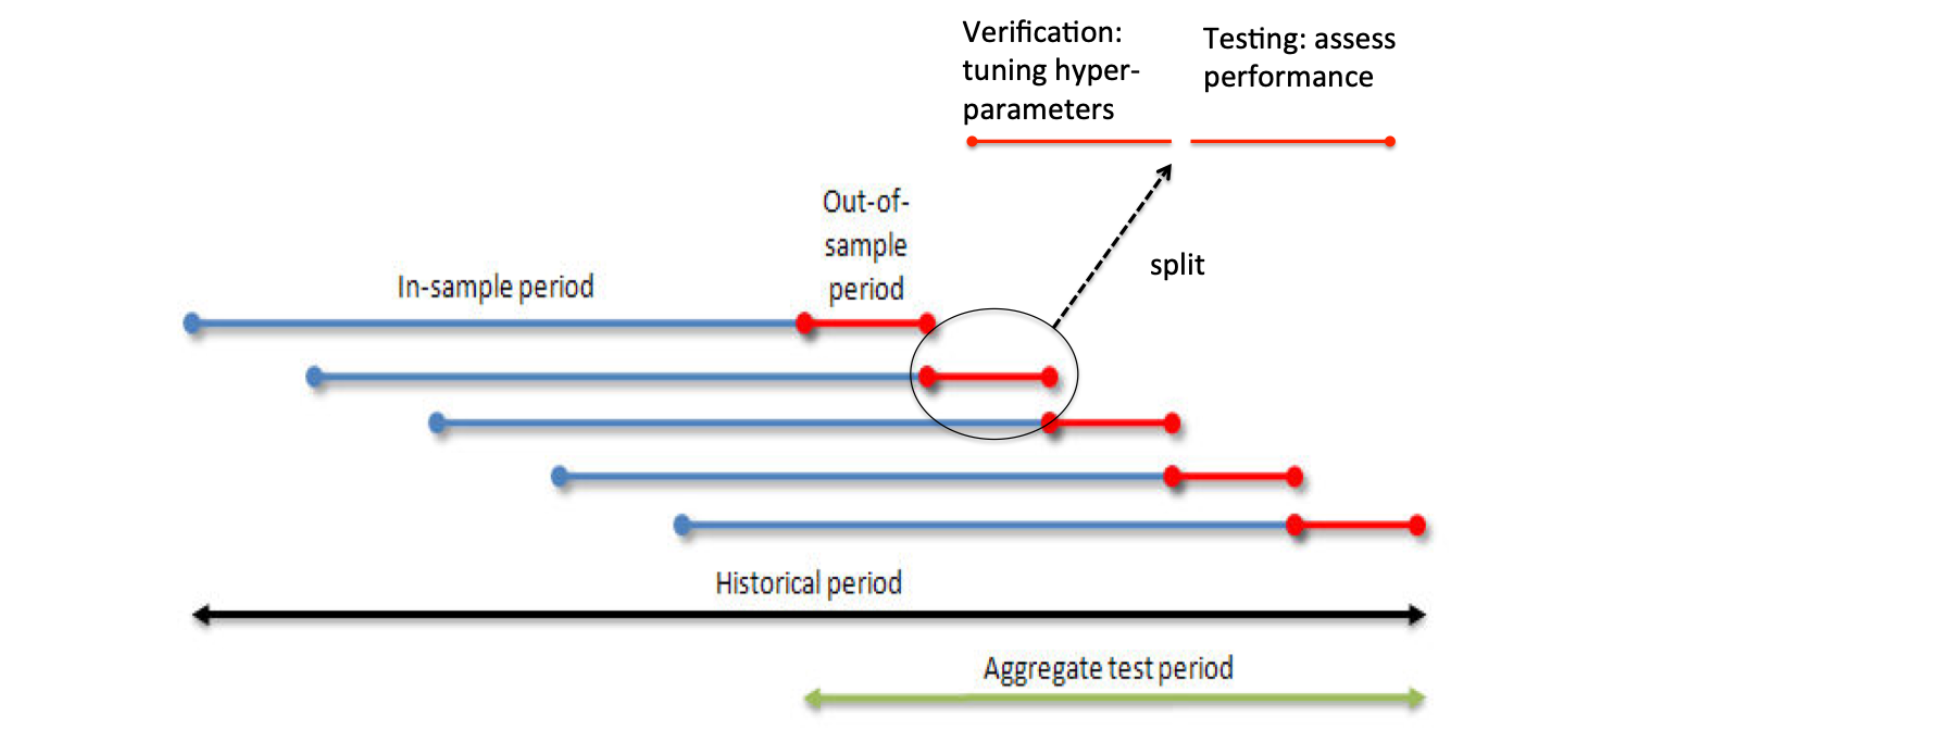

Times series cross validation, also referred to as walk forward optimization, is used instead of standard cross validation to preserve the ordering of the data. This avoids look-ahead bias in the fitted model which occurs when one or more observations in the training set are from the future.

# Evaluation Metrics

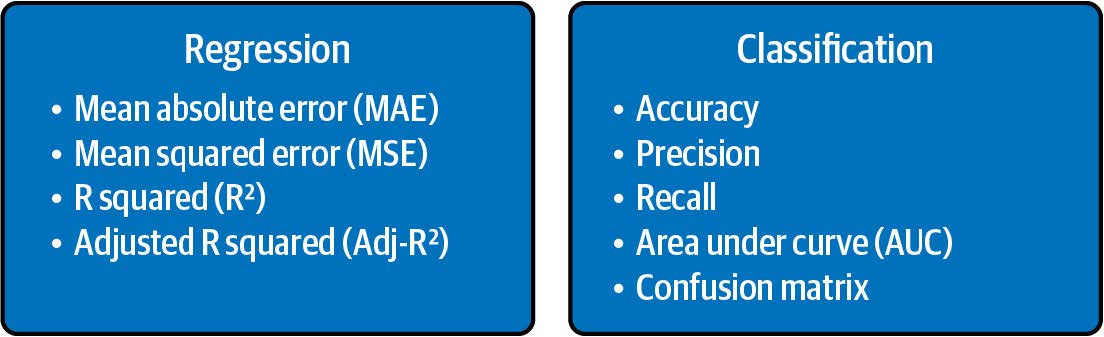

# Accuracy, Precision, and Recall

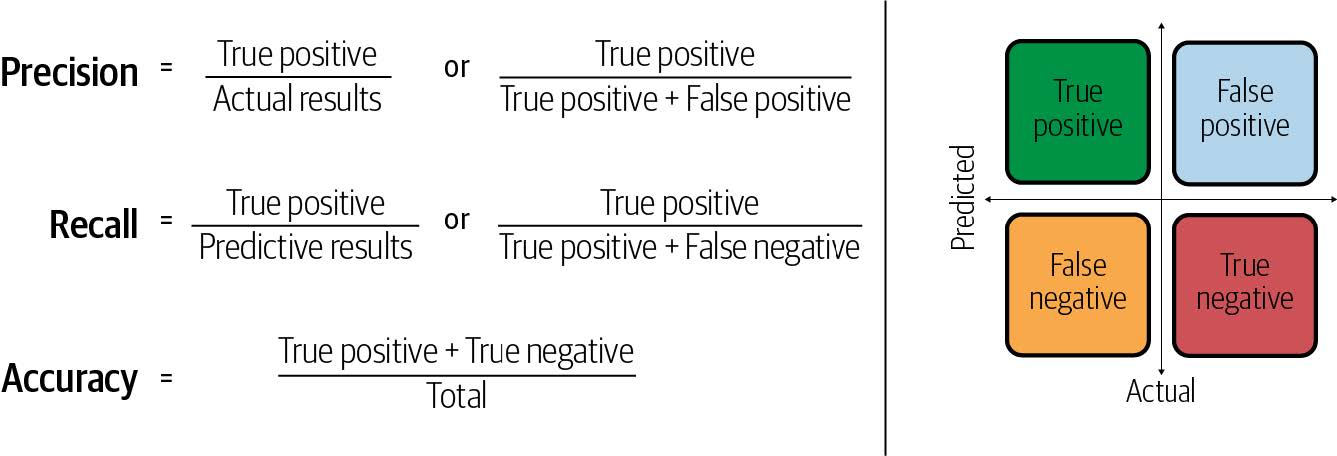

# Confusion matrix

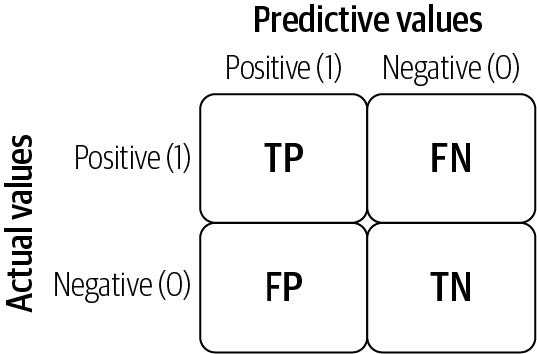

# Model Selection

The next slide compares the supervised learning models and outlines a general rule-of-thumb to narrow down the search for the best machine learning algorithm for a given problem. The table is based on the advantages and disadvantages of different models.

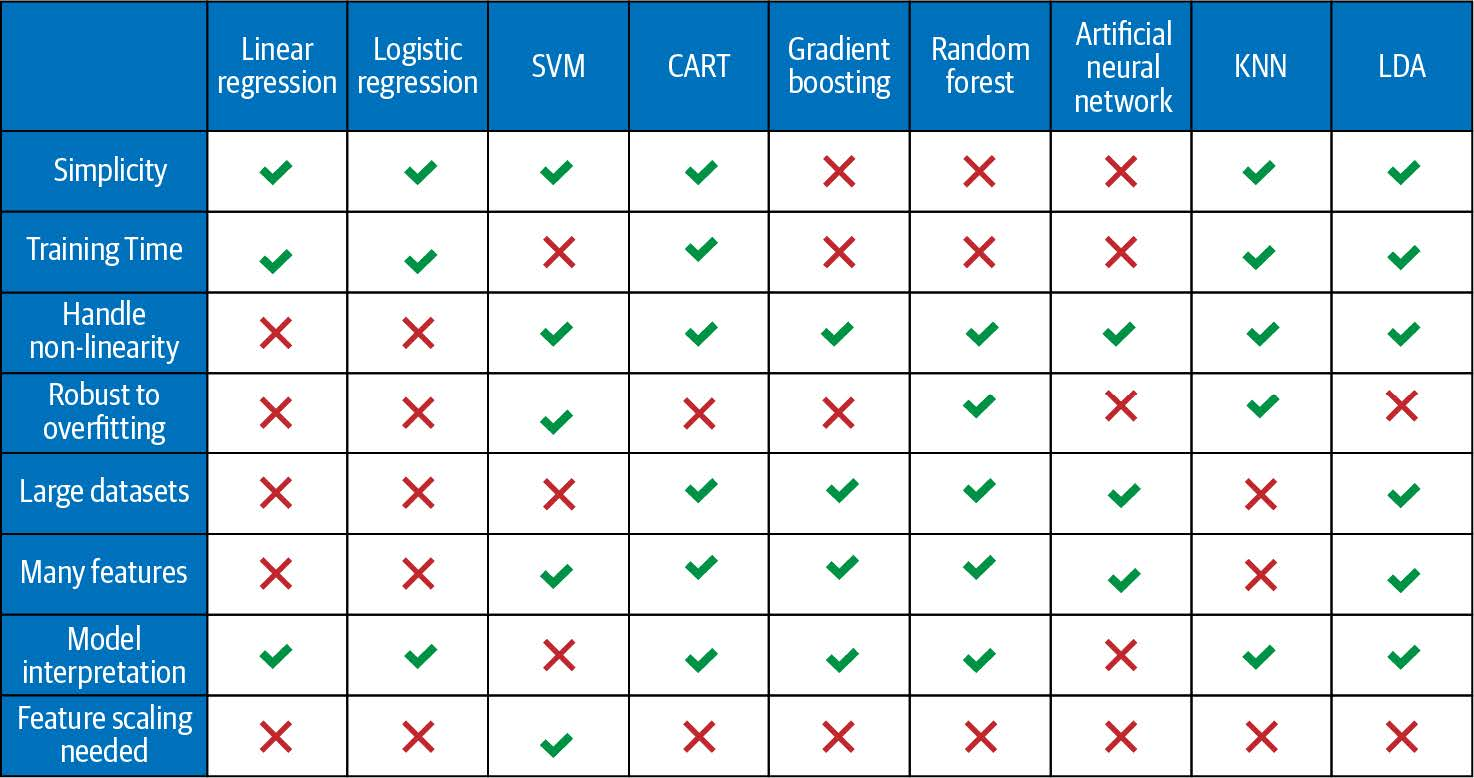

# AI Acts 

The EU AI Rulebook, the AI Act, will be effective starting 2027. 


# Technical Documentation

- __[Datasheets](https://arxiv.org/pdf/1803.09010.pdf) for Datasets:__ Overview of motivation, composition, collection process, preprocessing/cleaning/labeling, distribution and maintenance.

- __[Model Cards](https://arxiv.org/pdf/1810.03993.pdf) for Model Reporting:__ Model details, intended use, factors, metrics, training data, evaluation data, ethical considerations, caveats and recommendations.

# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
from pylab import mpl, plt
from pandas import read_csv, set_option
from importlib import reload 
import sys
import os


# imports for plotting
from pandas.plotting import scatter_matrix
import seaborn as sns

# imports from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings(action='ignore')

# custom library
py_file_location = '../../'
sys.path.append(os.path.abspath(py_file_location))
from customlib import technical_analysis as ta
from customlib import plotting as pl

In [3]:
# custom styled plotting settings
%matplotlib inline
#sns.set_style('whitegrid', {'axes.facecolor': '.95'})
plt.style.use('../../custom_plot_style.mplstyle') # use the custom style sheet

# use custom styed font and image settings 
mpl.rcParams['font.family'] = 'sans-serif' 
mpl.rcParams['font.sans-serif'] = ['Tahoma']
%config InlineBackend.figure_format = 'svg'

## Loading the Data

In [4]:
# use relative paths!
PATH = '../../data/'

# load dataset
dataset = pd.read_csv(PATH + 'BitstampData.csv')

# EDA

## Descriptive Statistics

In [5]:
# get shape of dataset
dataset.shape

In [6]:
# get some more intuition of the dataset
dataset.tail(2)

In [7]:
# describe data
dataset.describe()

# Data Preparation

## Data Cleaning

In [8]:
# check for any null values
try:    
    assert(dataset.isnull().values.any() == True)
    dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()
    print('Removed Null values.')
except:
    print('There are no Null values to remove.')

In [9]:
dataset=dataset.drop(columns=['Timestamp'])

## Preparing the data for classification

We attach a label to each movement: 
* **1** if the signal is that short term price will go up as compared to the long term. 
* **0** if the signal is that short term price will go down as compared to the long term.

In [10]:
# create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

dataset.tail(2)

## Feature Engineering

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bitcoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:

* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index (RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change (ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [11]:
# calculation of exponential moving average
dataset['EMA10'] = ta.EMA(dataset, 10)
dataset['EMA30'] = ta.EMA(dataset, 30)
dataset['EMA200'] = ta.EMA(dataset, 200)

# calculation of rate of change
dataset['ROC10'] = ta.ROC(dataset['Close'], 10)
dataset['ROC30'] = ta.ROC(dataset['Close'], 30)

# calculation of price momentum
dataset['MOM10'] = ta.MOM(dataset['Close'], 10)
dataset['MOM30'] = ta.MOM(dataset['Close'], 30)

# calculation of relative strength index
dataset['RSI10'] = ta.RSI(dataset['Close'], 10)
dataset['RSI30'] = ta.RSI(dataset['Close'], 30)
dataset['RSI200'] = ta.RSI(dataset['Close'], 200)

# calculation of stochastic osillator.
dataset['%K10'] = ta.STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = ta.STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = ta.STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = ta.STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = ta.STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = ta.STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

# calculation of moving average
dataset['MA21'] = ta.MA(dataset, 10)
dataset['MA63'] = ta.MA(dataset, 30)
dataset['MA252'] = ta.MA(dataset, 200)

In [12]:
dataset.tail(5)

In [13]:
# drop unneeded columns
dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

# drop Nans
dataset = dataset.dropna(axis=0)

dataset.tail(2)

## Data Visualization

In [14]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

In [15]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12));

In [16]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh')
plt.show()

The predicted variable is upward 52.87% out of total data-size, meaning that the number
of the buy signals were more than the number of sell signals. So, the predicted variable is relatively balanced, especially as compared to having for instance a fraud detection dataset, were we would have an inbalenced dataset.

In [17]:
reload(pl)

In [18]:
pl.heatmap_plot(dataset, 'Correlation Matrix', 'correlation_matrix_classification')

# Evaluate Algorithms and Models

## Train Test Split

We split the dataset into 80% training set and 20% test set.

In [19]:
# split the validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset['signal']
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

## Test Options and Evaluation Metrics


In [20]:
# test options for classification
num_folds = 10
seed = 42

# Accuracy can be used as the evaluation metric 
# since there is not a significant class imbalance in the data.
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

## Compare Models and Algorithms

In order to know which algorithm technic is the best for our strategy, we evaluate following non linear different methods:

### Models

In [21]:
# initialize the models
models = []

# Linear method
models.append(('LDA', LinearDiscriminantAnalysis()))

# Regression based methods
models.append(('LR', LogisticRegression(n_jobs=-1, solver='saga')))
models.append(('KNN', KNeighborsClassifier()))

# Non-linear method
models.append(('DTree', DecisionTreeClassifier()))

# Ensable, Boosting methods
models.append(('Ada Boost ', AdaBoostClassifier()))
models.append(('GBoost', GradientBoostingClassifier()))

# Ensable, Bagging methods
models.append(('RForest', RandomForestClassifier(n_jobs=-1)))

In [22]:
results = []
names = []
# loop over the models list
for name, model in models:
    tscv = TimeSeriesSplit(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=tscv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [23]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison: tscv results')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Scores')
ax.set_xlabel('Models')
fig.set_size_inches(10,5)
plt.show()

# Model Tuning and Grid Search

Random forest is selected for the grid search as it is one of the best models out of all.

Although some of the models show promising results, we prefer an ensemble model given the huge size of the dataset, the large number of features, and an expected nonlinear relationship between the predicted variable and the features. Random forest has the best performance among the ensemble models.

In [24]:
# Grid Search only for Random Forest Classifier

'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
''' 

In [25]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,100]
max_depth= [5,20]
criterion = ['gini','entropy']
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=tscv)
grid_result = grid.fit(rescaledX, Y_train)

# print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

# Finalise the Model

Finalizing the model with best parameters found during tuning step.

## Results on the Test Dataset

In [26]:
best_params = grid_result.best_params_
criterion = list(best_params.values())[0]
max_depth = list(best_params.values())[1]
n_estimators = list(best_params.values())[2]

print('Best criterion: ', criterion)
print('Best numer of estimators: ', n_estimators)
print('Best max depth: ', max_depth)

In [27]:
# prepare model for training with best params
model = RandomForestClassifier(criterion=criterion, n_estimators=n_estimators,max_depth=max_depth,n_jobs=-1) 
# rbf is default kernel
model.fit(X_train, Y_train)

In [28]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

In [29]:
# The selected model performs quite well, with an accuracy of 93.17%. Let us look at the confusion matrix:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16});# font sizes

## Variable Intuition/Feature Importance

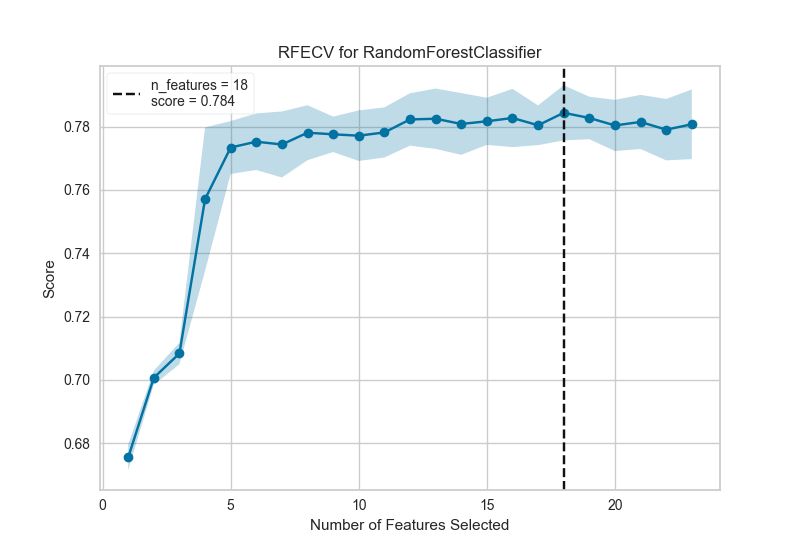

In [30]:
# The result of the variable importance looks intuitive, and the momentum indicators
# of RSI and MOM over the last 30 days seem to be the two most important features.
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh')
plt.xlabel('Variable Importance')
plt.title('Feature Importance', fontsize=20);

## Backtesting Results

In [31]:
# Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
# of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)

In [32]:
backtestdata=backtestdata.reset_index()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot();

Looking at the backtesting results, we do not deviate significantly from the actual market return. Indeed, the achieved momentum trading strategy made us better at predicting the price direction to buy or sell in order to make profits. However, as our accuracy is not 100%, but still, we made relatively few losses compared to the actual returns.